In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

import transformers
from transformers import modeling_outputs

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as F


import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from pyvis.network import Network

/home/insane/.pyenv/versions/3.12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pretty_print(*objs, indent=0):
    spacing = ' ' * indent
    for obj in objs:
        if isinstance(obj, dict):
            print(f"{spacing}{{")
            for key, value in obj.items():
                print(f"{spacing}  {key}:")
                pretty_print(value, indent + 4)
            print(f"{spacing}}}")
        elif isinstance(obj, (list, tuple)):
            print(f"{spacing}[")
            for item in obj:
                pretty_print(item, indent + 4)
            print(f"{spacing}]")
        elif isinstance(obj, np.ndarray):
            print(f"{spacing}np.array[{obj.dtype}] (shape: {obj.shape})")
        elif isinstance(obj, torch.Tensor):
            print(f"{spacing}torch.Tensor[{obj.dtype}] (shape: {obj.shape})")
        elif isinstance(obj, torch.nn.Module):
            print(f"{spacing}torch.nn.Module[{obj.dtype}] (shape: {obj.shape})")
        elif isinstance(obj, transformers.tokenization_utils_base.BatchEncoding):
            print(f"{spacing}BatchEncoding (keys: {list(obj.keys())})")
            for key, value in obj.items():
                print(f"{spacing}  {key}:")
                pretty_print(value, indent + 4)
        else:
            print(f"{spacing}{obj}")
            
def visualize_with_pyvis(G, width="1920px", height="1080px", hierarchical=False, file_name="pytorch_model_graph.html"):
    # Create a PyVis network object
    net = Network(notebook=False, directed=True, width=width, height=height)

    # Add nodes and edges from the NetworkX graph
    for node, data in G.nodes(data=True):
        net.add_node(node, title=str(data), label=node)

    for source, target, data in G.edges(data=True):
        net.add_edge(source, target, title=str(data))

    # Apply hierarchical layout
    net.repulsion(
        node_distance=120,
        central_gravity=0.33,
        spring_length=100,
        spring_strength=0.10,
        damping=0.95,
    )

    options = {
        # "layout": {
        # }
    }
    if hierarchical:
        options["layout"] = {
            "hierarchical": {
                "enabled": True,
                "levelSeparation": 250,
                "nodeSpacing": 400,
                "treeSpacing": 200,
                "blockShifting": False,
                "edgeMinimization": True,
                "parentCentralization": True,
                "direction": "UD",
                "sortMethod": "directed",
            }
        }
        net.set_options(json.dumps(options))
    else:
        net.show_buttons()
        net.toggle_physics(True)  # Enable physics for better layout

    # Save the network to an HTML file
    net.save_graph(file_name)

In [3]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16.eval()
inceptionv3 = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
gpt2 = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id
gpt2.eval()
vit = transformers.AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
vit.eval()
imagenette = torchvision.datasets.ImageFolder(root='/home/insane/U/apalysis-evaluation/dataset-5', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]))
gpt2_custom = [
    'Hello world, sdjfklasdj ksdj fskdj lfskdj fklsadjf lskadjf laskdjf klasdjf klasd jfklasdj fklasd jfklasd jflaksjdf klasdjf aklsdjf klasjd fklasdj fklasfj',
    'I love you',
    'This is my world',
    'Hello, how are you? I am fine, thank you!',
    'Tell me a story on the moon',
]

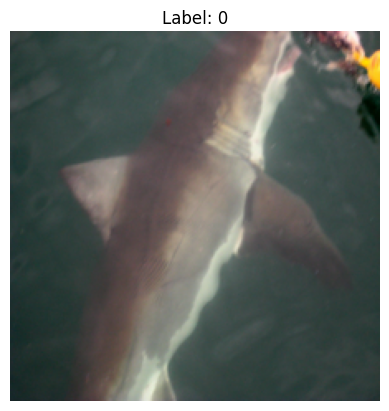

In [4]:
# Display the first image from the imagenette dataset
image, label = imagenette[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [5]:
def vgg16_preprocess(x: torch.Tensor):
    x = F.resize(x, [224, 224])
    x = F.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return x

def inceptionv3_preprocess(x):
    x = F.resize(x, [299, 299])
    x = F.to_tensor(x)
    x = F.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return x

def gpt2_preprocess(x):
    tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    x = tokenizer(x, return_tensors='pt', padding=True, truncation=True)
    return x

input_vgg16 = torch.stack([vgg16_preprocess(x) for x, _ in imagenette])
input_inceptionv3 = np.array([x for x, _ in imagenette])
input_gpt2 = gpt2_preprocess(gpt2_custom)
input_vit = np.array([x for x, _ in imagenette])

pretty_print(input_vgg16)
pretty_print(input_inceptionv3)
pretty_print(input_gpt2)
pretty_print(input_vit)

torch.Tensor[torch.float32] (shape: torch.Size([25, 3, 224, 224]))
np.array[float32] (shape: (25, 3, 224, 224))
BatchEncoding (keys: ['input_ids', 'attention_mask'])
  input_ids:
torch.Tensor[torch.int64] (shape: torch.Size([5, 79]))
4
  attention_mask:
torch.Tensor[torch.int64] (shape: torch.Size([5, 79]))
4
np.array[float32] (shape: (25, 3, 224, 224))


In [6]:
vgg16_layers = list(
    map(
        lambda l: l[0],
        vgg16.named_modules()
    )
)

inceptionv3_layers = list(
    map(
        lambda l: l[0],
        inceptionv3.named_modules()
    )
)

gpt2_layers = list(
    map(
        lambda l: l[0],
        gpt2.transformer.named_modules()
    )
)

vit_layers = list(
    map(
        lambda l: l[0],
        vit.named_modules()
    )
)

print(vgg16_layers)
print(inceptionv3_layers)
print(gpt2_layers)
print(vit_layers)

['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
['', 'Conv2d_1a_3x3', 'Conv2d_1a_3x3.conv', 'Conv2d_1a_3x3.bn', 'Conv2d_2a_3x3', 'Conv2d_2a_3x3.conv', 'Conv2d_2a_3x3.bn', 'Conv2d_2b_3x3', 'Conv2d_2b_3x3.conv', 'Conv2d_2b_3x3.bn', 'maxpool1', 'Conv2d_3b_1x1', 'Conv2d_3b_1x1.conv', 'Conv2d_3b_1x1.bn', 'Conv2d_4a_3x3', 'Conv2d_4a_3x3.conv', 'Conv2d_4a_3x3.bn', 'maxpool2', 'Mixed_5b', 'Mixed_5b.branch1x1', 'Mixed_5b.branch1x1.conv', 'Mixed

In [24]:
# Function to create unique layer names
def get_layer_name(module_name: str, parent_name: str = "") -> str:
    if parent_name:
        return f"{parent_name}_{module_name}"
    return module_name
# Hook function to add nodes and edges to the graph

def add_to_graph(G: nx.MultiDiGraph, module: torch.nn.Module | torch.nn.ModuleList | torch.nn.Sequential | torch.nn.ModuleDict, layer_name: str, output: torch.Tensor | tuple[torch.Tensor, ...] | dict[str, torch.Tensor], parent_name: str | None, previous_layer_name: str | None) -> None:
    """
    Convert a PyTorch model to a networkx graph representation.

    Args:
    - model (torch.nn.Module): The PyTorch model to convert.
    - input_tensor (Union[torch.Tensor, dict, transformers.tokenization_utils_base.BatchEncoding]): A sample input tensor to perform a forward pass and generate outputs.

    Returns:
    - nx.DiGraph: A directed graph representing the model with nodes as layers and edges as data flow between layers.
    """
    # Get the layer type, dtype, and shape
    layer_type = module.__class__.__name__
    if isinstance(output, tuple):
        output = output[0]
    elif isinstance(output, dict):
        if 'last_hidden_state' in output:
            output = output['last_hidden_state']
        elif 'logits' in output:
            output = output['logits']
        else:
            raise ValueError(f"Unknown output type: {output}")
    output_type = str(output.dtype)
    output_shape = tuple(output.shape)

    # Add node with attributes
    G.add_node(
        layer_name,
        output=output,
        output_type=output_type,
        output_shape=output_shape,
        layer_type=layer_type,
    )

    # Add edge from the previous layer to the current layer if it's not the input layer
    if previous_layer_name:
        G.add_edge(previous_layer_name, layer_name, edge_type="data_flow")

    if parent_name:
        G.add_edge(parent_name, layer_name, edge_type="parent")

def extract_activations_graph(model: torch.nn.Module | torch.nn.ModuleList | torch.nn.Sequential | torch.nn.ModuleDict, input_tensor: torch.Tensor | dict | transformers.tokenization_utils_base.BatchEncoding) -> nx.DiGraph:
    """
    Convert a PyTorch model to a networkx graph representation.

    Args:
    - model (torch.nn.Module): The PyTorch model to convert.
    - input_tensor (Union[torch.Tensor, dict, transformers.tokenization_utils_base.BatchEncoding]): A sample input tensor to perform a forward pass and generate outputs.

    Returns:
    - nx.DiGraph: A directed graph representing the model with nodes as layers and edges as data flow between layers.
    """
    G = nx.MultiDiGraph()
    
    # Function to recursively register hooks on all layers
    def register_hooks(module: torch.nn.Module | torch.nn.ModuleList | torch.nn.Sequential | torch.nn.ModuleDict, module_name: str, parent_name: str | None, previous_layer_name: str | None = None) -> None:
        module.register_forward_hook(lambda module, input, output: add_to_graph(G, module, module_name, output, parent_name, previous_layer_name))
        this_previous_layer_name = previous_layer_name if previous_layer_name is None else previous_layer_name[:]
        for i, (name, child_module) in enumerate(module.named_children()):
            current_child_name = get_layer_name(name, module_name)
            register_hooks(child_module, current_child_name, module_name, (module_name if i == 0 else this_previous_layer_name))
            this_previous_layer_name = current_child_name

    # Register hooks starting from the root model
    register_hooks(model, type(model).__name__, None)

    try:
        # Perform a forward pass with the input tensor to populate the graph
        with torch.no_grad():
            if isinstance(input_tensor, (dict, transformers.tokenization_utils_base.BatchEncoding)):
                model(**input_tensor)
            else:
                model(input_tensor)
    finally:
        # remove all hooks
        for module in model.modules():
            module._forward_hooks.clear()
            module._forward_pre_hooks.clear()
            
    changed = True
    while changed:
        changed = False
        for VGG_features, VGG_features_30, d1 in G.edges(data=True):
            if d1['edge_type'] == 'parent':
                # Get all other edges between these two nodes
                if [(u, v, d) for u, v, d in G.edges(data=True) if u == VGG_features_30 and v == VGG_features and d['edge_type'] == 'data_flow']:
                    changed = True
                    G.remove_edge(VGG_features_30, VGG_features)
                    # Get all the nodes to where VGG_features is connected with an edge of type data_flow
                    incident_nodes = [v for u, v, d in G.edges(data=True) if u == VGG_features and d.get('edge_type') == 'data_flow']
                    for node in incident_nodes:
                        G.add_edge(VGG_features_30, node, edge_type='data_flow')
                        
    return G



model_graph = extract_activations_graph(vgg16, input_vgg16)
visualize_with_pyvis(model_graph, file_name="whole_model.html")

model_graph_hierarchy = nx.DiGraph((u, v, d) for u, v, d in model_graph.edges(data=True) if d.get('edge_type') == 'parent')
assert nx.is_directed_acyclic_graph(model_graph_hierarchy), "The graph must be acyclic!"
nodes_not_in_hierarchy = set(model_graph.nodes()) - set(model_graph_hierarchy.nodes())
print("Nodes not in model_graph_hierarchy:", nodes_not_in_hierarchy)
model_graph_hierarchy.add_nodes_from([(node, data) for node, data in model_graph.nodes(data=True) if node in nodes_not_in_hierarchy])
visualize_with_pyvis(model_graph_hierarchy, file_name="whole_model_hierarchy.html", hierarchical=True)

model_graph_dataflow = nx.DiGraph((u, v, d) for u, v, d in model_graph.edges(data=True) if d['edge_type'] == 'data_flow')
nodes_not_in_dataflow = set(model_graph.nodes()) - set(model_graph_dataflow.nodes())
print("Nodes not in model_graph_dataflow:", nodes_not_in_dataflow)
model_graph_dataflow.add_nodes_from([(node, data) for node, data in model_graph.nodes(data=True) if node in nodes_not_in_dataflow])
visualize_with_pyvis(model_graph_dataflow, file_name="whole_model_data_flow.html")

Nodes not in model_graph_hierarchy: set()
Nodes not in model_graph_dataflow: set()
